
### 1.Introduction
In this notebook, we will analyze the vaccine data to understand various factors and their correlation with the outcome 'DIED'. We will perform feature selection, split the data into training and testing sets, and prepare it for model training.


In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from pylab import rcParams
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics  import confusion_matrix
warnings.filterwarnings('ignore')

### 2. Data Collection

The Vaccine Adverse Event Reporting System (VAERS) is a national system for monitoring the safety of vaccines in the United States. It is co-managed by the Centers for Disease Control and Prevention (CDC) and the Food and Drug Administration (FDA). VAERS collects and analyzes data on adverse events that occur after the administration of vaccines, which helps in identifying potential safety concerns.

#### Key Points about VAERS:
1. **Purpose**:
    - VAERS serves as an early warning system to detect possible safety issues with vaccines.
    - It provides a national database for healthcare providers, manufacturers, and the public to report adverse events.

2. **Data Collection**:
    - VAERS accepts reports from healthcare providers, vaccine manufacturers, and the public.
    - The data collected includes information on the patient, the vaccine administered, and the adverse event experienced.

3. **Data Usage**:
    - The data is used to monitor vaccine safety and to conduct research studies.
    - VAERS data is accessible to the public and researchers to promote transparency and further study.

4. **Impact**:
    - VAERS has played a crucial role in ensuring the safety of vaccines by identifying and addressing potential safety issues.
    - It contributes to the continuous monitoring and evaluation of vaccines, thereby maintaining public confidence in vaccination programs.

In this project, we use data from VAERS to analyze various factors and their correlation with adverse events, specifically focusing on outcomes related to mortality (`DIED`). This analysis helps in understanding the impact of different variables on vaccine safety and effectiveness.

### 3. Load Data

This section focuses on reading and preprocessing vaccine data from an Excel file. The steps include filtering for COVID-19 vaccine records, removing any duplicate entries, and resetting the index for a clean and orderly dataset. This preprocessing ensures that the data is ready for further analysis or modeling tasks.

Key steps:
1. **Read Data**: Load data from the specified Excel file into a pandas DataFrame.
2. **Filter Data**: Extract only the records related to COVID-19 vaccines.
3. **Remove Duplicates**: Eliminate duplicate rows to maintain data integrity.
4. **Reset Index**: Reindex the DataFrame to ensure a continuous index starting from 0.

In [27]:
# Read the Excel file into a DataFrame
df_vaccine = pd.read_excel('/content/drive/MyDrive/last_document.xlsx')

# Filter the DataFrame for COVID-19 vaccine type
df_vaccine = df_vaccine[df_vaccine['VAX_TYPE'] == 'COVID19']

# Drop duplicate rows
df_vaccine = df_vaccine.drop_duplicates()

# Reset the index of the DataFrame
df_vaccine = df_vaccine.reset_index(drop=True)


### 4. Exploratory Data Analysis  

In the following code block, we focus on identifying and counting unique cases where the outcome was death (DIED == 'Y') in the dataset. The calculation yields the number of unique VAERS IDs corresponding to these fatal cases. This information is crucial for understanding the impact and frequency of severe outcomes related to the vaccines.

In [28]:
unique_fatal_cases = (df_vaccine[df_vaccine['DIED'] == 'Y'])['2021VAERSDATA_VAERS_ID'].unique().size
print(unique_fatal_cases)

1957


next , we focus on retrieving and examining the unique values in the HISTORY column of the vaccine dataset. Understanding the variety of medical histories recorded can provide insights into the background conditions of individuals receiving the vaccine.

In [29]:
unique_histories = df_vaccine['HISTORY'].unique()
print(unique_histories)


[nan 'Patient residing at nursing facility. See patients chart.'
 'diverticulitis, mitral valve prolapse, osteoarthritis' ...
 'Medical History/Concurrent Conditions: Aortic valve replacement'
 'Medical History/Concurrent Conditions: Type II diabetes mellitus'
 'Comments: List of non-encoded Patient Relevant History: Patient Other Relevant History 1: no adverse event, Continue: [UNK], Comment: No medical history reported']


let's focus on retrieving and examining the unique values in the VAX_TYPE column of the vaccine dataset. Understanding the variety of vaccine names recorded can provide insights into the different vaccines administered.

In [30]:
unique_vaccine_names = df_vaccine['VAX_TYPE'].unique()
print(unique_vaccine_names)


['COVID19' 'UNK' 'FLU4' 'RV1' 'HIBV' 'DTAPHEPBIP' 'FLUX' 'HEP' 'PPV'
 'VARZOS' 'FLUC3' 'FLUC4' 'PNC13' 'MMR' 'DTAP' 'HPV9' 'CHOL' 'TTOX' 'DT'
 'FLU3' 'FLUR4' 'MNQ' 'HPV4' 'TDAP' 'FLUA3' 'VARCEL' 'HEPA' 'FLUA4' 'ANTH'
 'IPV' 'TYP' 'HPVX' 'DTP' 'DTAPIPVHIB' 'RV5' 'MENB' 'RAB' 'FLUN4' 'PNC'
 'OPV' 'YF']


In [31]:
# Filter the DataFrame to keep only the COVID Vaccine
df_vaccine_filtered = df_vaccine[df_vaccine['VAX_TYPE']=='COVID19']

df_vaccine_filtered.head(5)


,2021VAERSDATA_VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,SYMPTOM5,SYMPTOMVERSION5,2021VAERSVAX_VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,916600,2021-01-01,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,NaN,NaN,916600,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))
1,916601,2021-01-01,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,NaN,NaN,916601,COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA))
2,916602,2021-01-01,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,NaN,NaN,916602,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
3,916603,2021-01-01,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,NaN,NaN,916603,COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA))
4,916604,2021-01-01,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,NaN,NaN,916604,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA))


In [32]:
# Filter the filtered DataFrame to include only rows where DIED is 'Y'
df_vaccine_died = df_vaccine_filtered[df_vaccine_filtered['DIED'] == 'Y'].drop_duplicates(subset=['2021VAERSDATA_VAERS_ID'])


# Count the number of unique VAERS IDs for fatal cases
unique_fatal_cases = df_vaccine_died['2021VAERSDATA_VAERS_ID'].unique().size

print(unique_fatal_cases)

1904



#### 4.1 Visualizations

In this section, we visualize the number of fatal cases (where DIED == 'Y') for each specified COVID-19 vaccine name using a bar graph. This helps in understanding the distribution of fatal cases across different vaccine types.

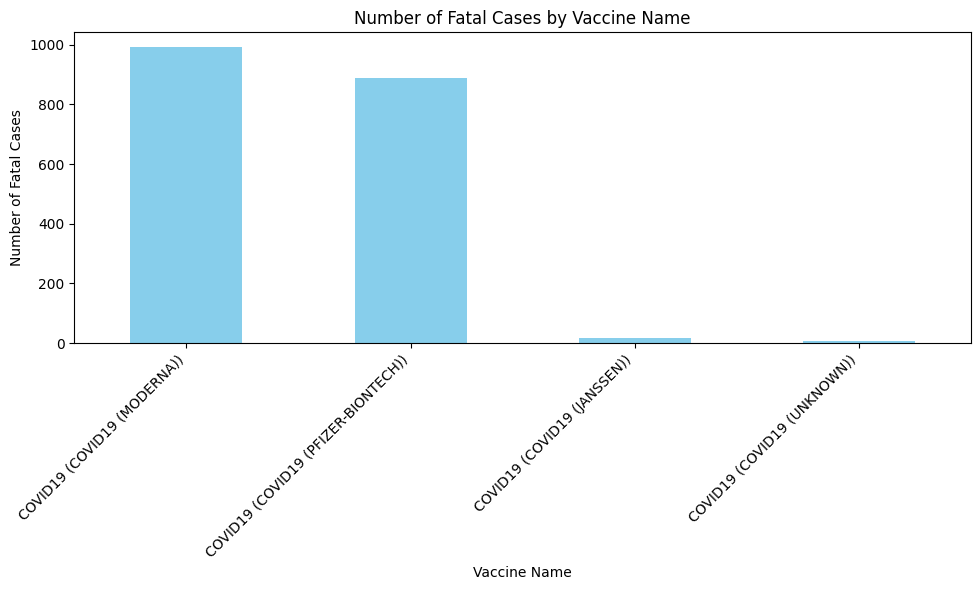

In [ ]:
fatal_cases_by_vaccine = df_vaccine_died['VAX_NAME'].value_counts()
# Plotting the bar graph
plt.figure(figsize=(10, 6))
fatal_cases_by_vaccine.plot(kind='bar', color='skyblue')
plt.title('Number of Fatal Cases by Vaccine Name')
plt.xlabel('Vaccine Name')
plt.ylabel('Number of Fatal Cases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In this section, we visualize the number of fatal cases (where DIED == 'Y') for each specified COVID-19 vaccine name, categorized by age group. This helps in understanding the distribution of fatal cases across different vaccine types and age groups.

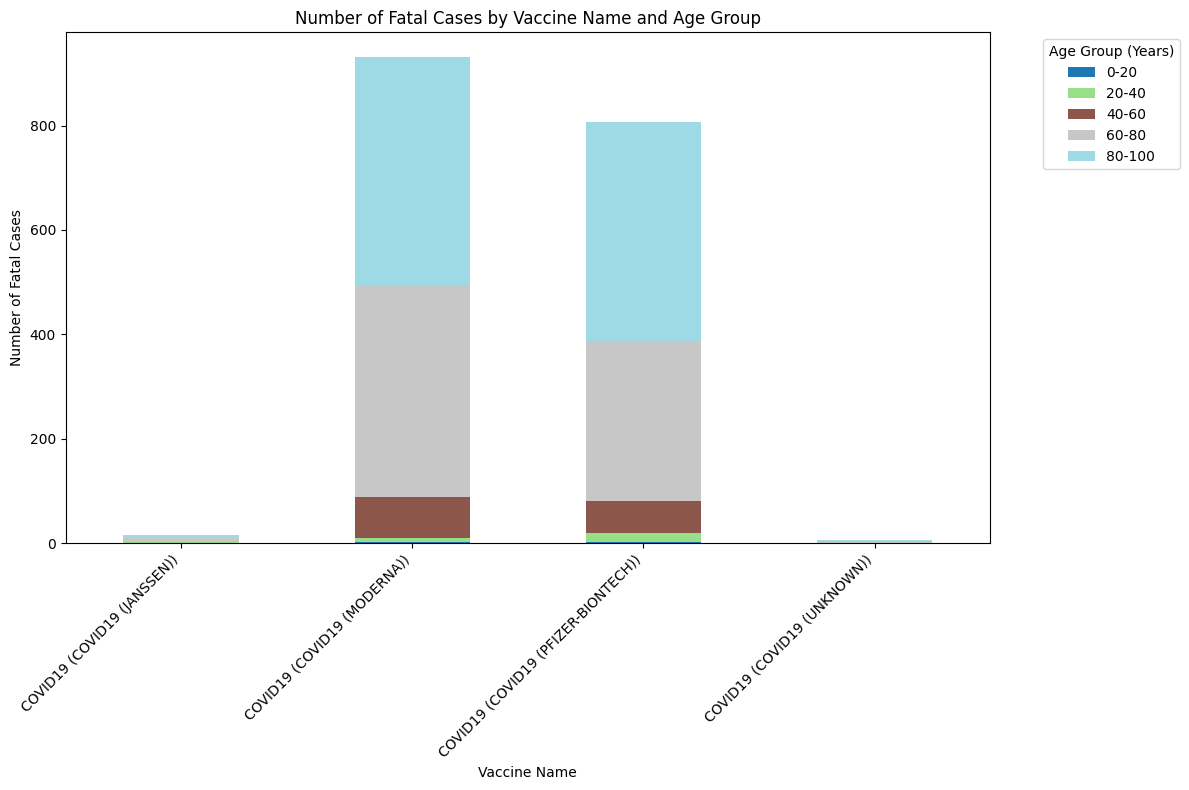

In [ ]:
# Define age bins and labels
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '20-40', '40-60', '60-80', '80-100']

# Add age group column to the DataFrame
df_vaccine_died['AGE_GROUP'] = pd.cut(df_vaccine_died['AGE_YRS'], bins=age_bins, labels=age_labels, right=False)

# Count the number of fatal cases for each vaccine name and their age group
fatal_cases_by_vaccine_and_age_group = df_vaccine_died.groupby(['VAX_NAME', 'AGE_GROUP']).size().unstack().fillna(0)

# Plotting the bar graph
fatal_cases_by_vaccine_and_age_group.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Number of Fatal Cases by Vaccine Name and Age Group')
plt.xlabel('Vaccine Name')
plt.ylabel('Number of Fatal Cases')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group (Years)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In this section, we perform data cleaning and preprocessing on specific columns of the dataset to ensure consistency and handle missing values. This preparation is necessary for accurate analysis and modeling.

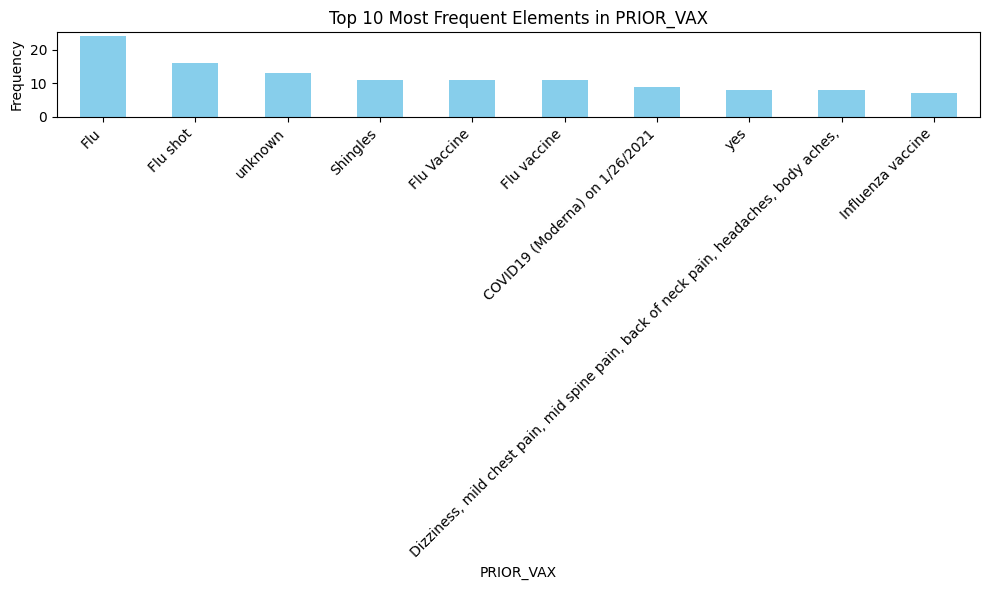

In [ ]:
# Ensure 'PRIOR_VAX' column is of string type
df_vaccine['PRIOR_VAX'] = df_vaccine['PRIOR_VAX'].astype(str)

# Replace specific values in 'PRIOR_VAX' column with 'y'
df_vaccine['PRIOR_VAX'] = df_vaccine['PRIOR_VAX'].replace('a', 'y')

# Reconfirm 'PRIOR_VAX' column is of string type
df_vaccine['PRIOR_VAX'] = df_vaccine['PRIOR_VAX'].astype(str)

# Filter out 'nan' values and count the top 10 most frequent elements
top_10_prior_vax = df_vaccine[df_vaccine['PRIOR_VAX'] != 'nan']['PRIOR_VAX'].value_counts().head(10)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
top_10_prior_vax.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Frequent Elements in PRIOR_VAX')
plt.xlabel('PRIOR_VAX')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


Analyzing V_FUNDBY in relation to Died



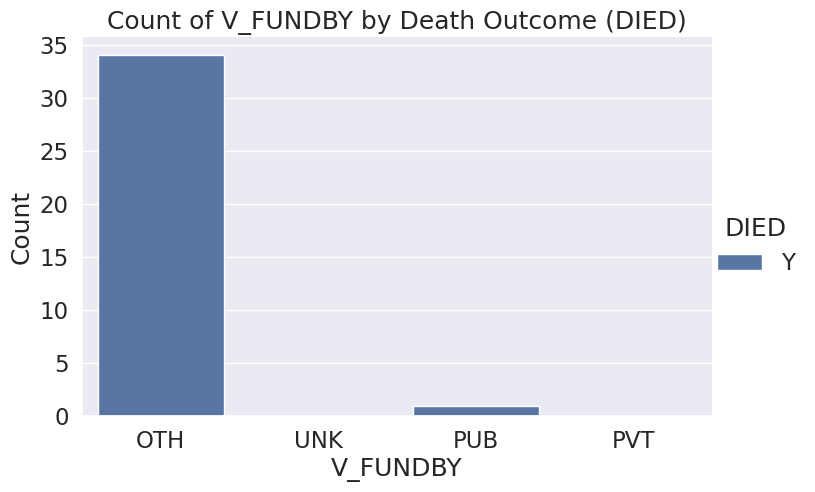


Analyzing SEX in relation to Died



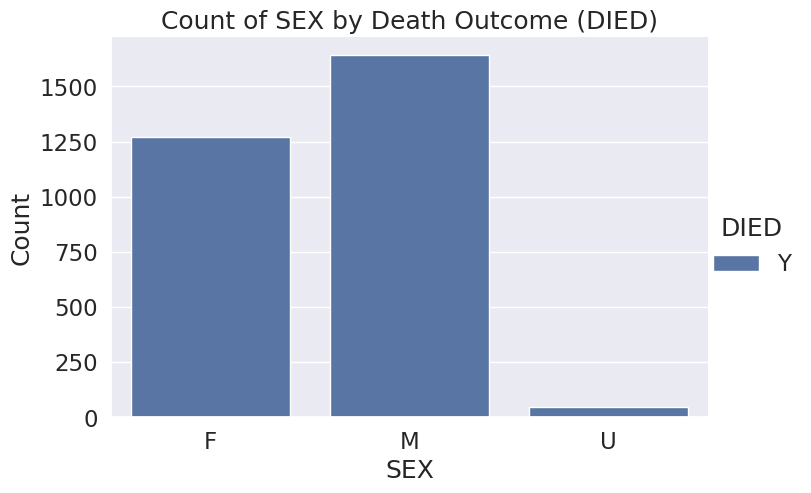


Analyzing HOSPITAL in relation to Died



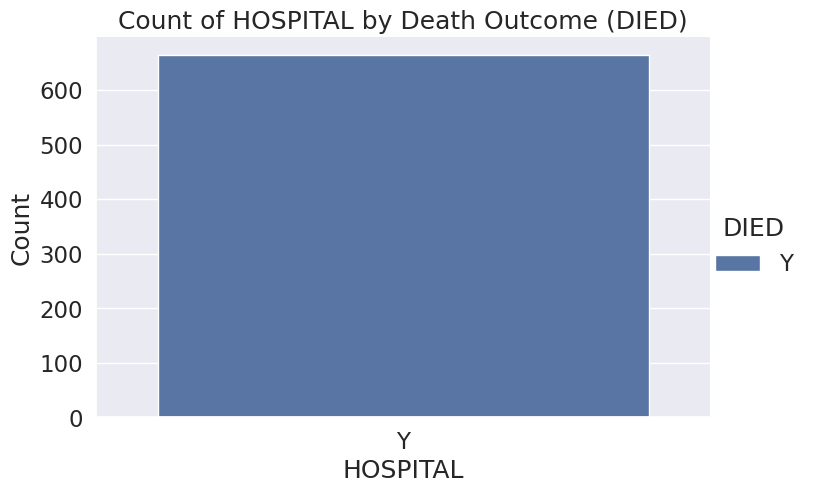


Analyzing L_THREAT in relation to Died



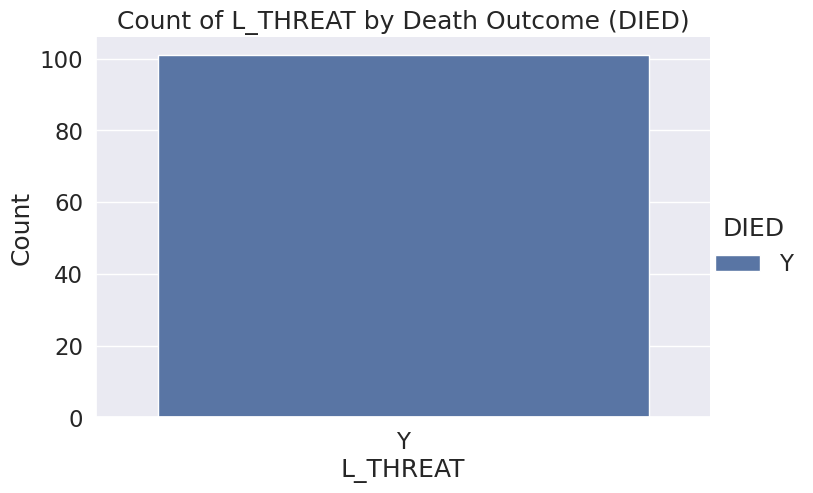


Analyzing DISABLE in relation to Died



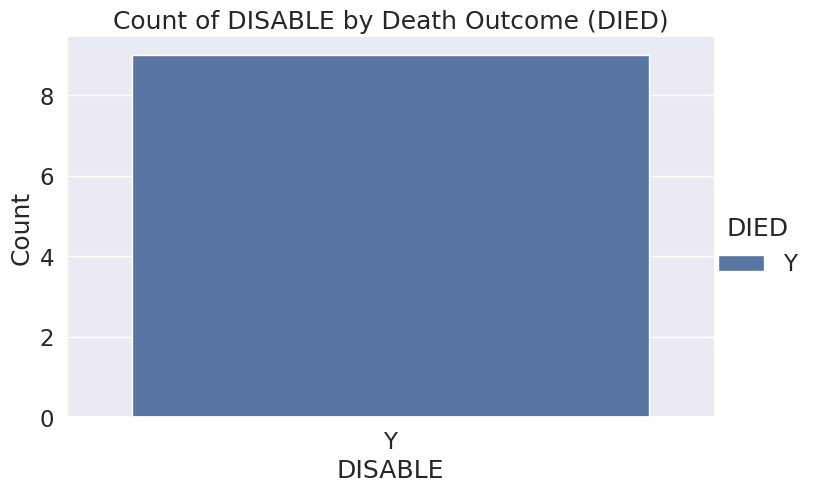


Analyzing ER_ED_VISIT in relation to Died



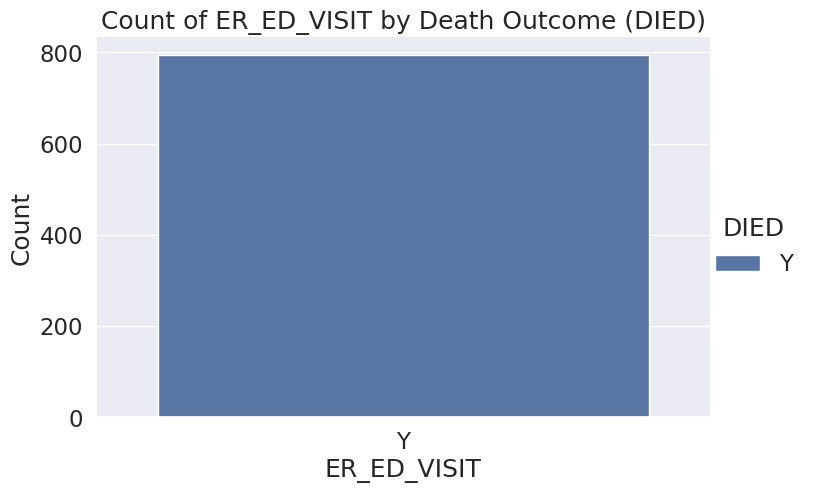


Analyzing VAX_ROUTE in relation to Died



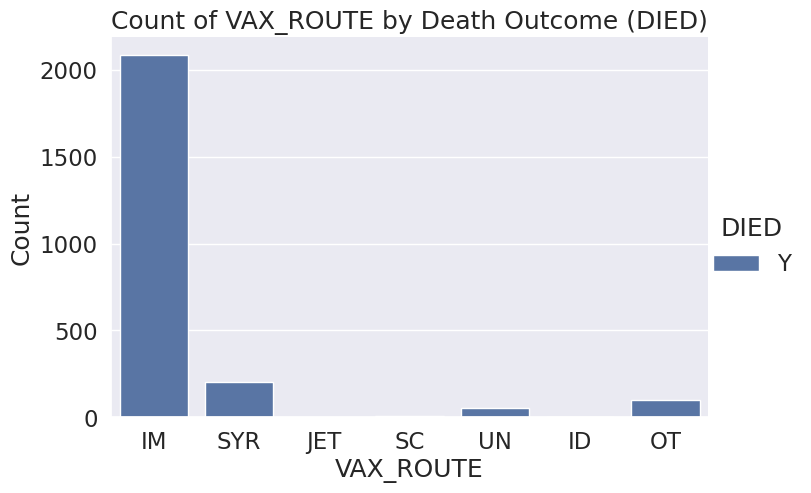


Analyzing DIED in relation to Died



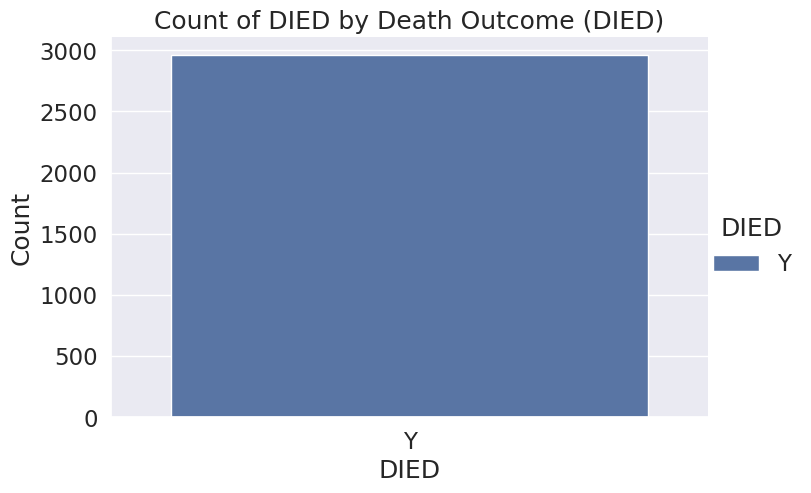

In [108]:
categoricalcols = ['V_FUNDBY', 'SEX', 'HOSPITAL', 'L_THREAT', 'DISABLE', 'ER_ED_VISIT', 'VAX_ROUTE', 'DIED']

# Loop through each categorical column and plot the count plot
for col in categoricalcols:
    print(f"\nAnalyzing {col} in relation to Died\n")

    # Create a count plot using seaborn
    sns.catplot(x=col, hue='DIED', data=df_vaccine_covid19, kind='count', height=5, aspect=1.5)

    # Set the title and labels for better understanding
    plt.title(f"Count of {col} by Death Outcome (DIED)")
    plt.xlabel(col)
    plt.ylabel("Count")

    # Show the plot
    plt.show()

we calculate the percentage of missing values for each column in the dataset and display the results in a sorted DataFrame. This helps in understanding the extent of missing data in each column and guides the decision-making process for data cleaning.

In [ ]:
# Calculate the percentage of missing values for each column
null_percent = df_vaccine.isnull().sum() * 100 / len(df_vaccine)

# Create a DataFrame to store the percentage of missing values
null_value_df = pd.DataFrame({'percent_missing': null_percent})

# Sort the DataFrame by the percentage of missing values in ascending order
null_value_df_sorted = null_value_df.sort_values(by='percent_missing')

# Filter out columns with 0% missing values
null_value_df_filtered = null_value_df_sorted[null_value_df_sorted['percent_missing'] > 0]

# Display the filtered DataFrame
null_value_df_filtered

,percent_missing
SYMPTOM_TEXT,0.030599
VAX_DOSE_SERIES,0.206034
VAX_DATE,3.604578
ONSET_DATE,4.445034
RECOVD,7.309112
AGE_YRS,7.670182
NUMDAYS,7.729340
STATE,13.928724
SYMPTOM2,18.157524
SYMPTOMVERSION2,18.157524


In [56]:
# Select relevant columns
df_vaccine = df_vaccine[['STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX', 'SYMPTOM_TEXT',
                         'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
                         'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS',
                         'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS',
                         'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'SYMPTOM1',
                         'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5', 'VAX_MANU',
                         'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'L_THREAT', 'DIED']]



In [74]:
df_died = df_vaccine[df_vaccine['DIED'] == 'Y']

# Select the symptom columns
symptom_cols = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']

# Create a list of lists for symptoms
transactions = df_died[symptom_cols].values.tolist()

# Remove NaN values from transactions
transactions = [[symptom for symptom in transaction if pd.notna(symptom)] for transaction in transactions]

# Encode the transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply FPGrowth algorithm
frequent_itemsets = fpgrowth(df_encoded,min_support=0.05,use_colnames=True)

# Print the results
print(frequent_itemsets)

    support                   itemsets
0  0.559217                    (Death)
1  0.068515  (Unresponsive to stimuli)
2  0.070799                 (Dyspnoea)
3  0.054486           (Cardiac arrest)


### 5. Data Pre-Processing

In [77]:

# Handling missing values
df_vaccine['CAGE_MO'] = df_vaccine['CAGE_MO'].fillna(0)

# Combining age in years and months into a single column
df_vaccine['CAGE_YR'] = df_vaccine['CAGE_YR'] + df_vaccine['CAGE_MO']

# Fill missing 'HOSPDAYS' values with 0
df_vaccine['HOSPDAYS'] = df_vaccine['HOSPDAYS'].fillna(0)

# Fill missing 'NUMDAYS' values with 0
df_vaccine['NUMDAYS'] = df_vaccine['NUMDAYS'].fillna(0)



In [76]:
# Select columns with object data types
object_columns = list(df_vaccine.select_dtypes(include=['object']).columns)

# Convert object columns to string
for col in object_columns:
    df_vaccine[col] = df_vaccine[col].astype(str)

# Initialize LabelEncoder
labelencoder = LabelEncoder()

# Encode each object column
for col in object_columns:
    df_vaccine[col] = labelencoder.fit_transform(df_vaccine[col])

In [82]:
age_columns = ['AGE_YRS', 'CAGE_YR']
for col in age_columns:
    std_dev = df_vaccine[col].std()
    df_vaccine[col] = df_vaccine[col].fillna(std_dev).astype(float)

In [83]:
# Calculate percentage of missing values for each column
null_percent = df_vaccine.isnull().sum() * 100 / len(df_vaccine)
null_value_df = pd.DataFrame({'percent_missing': null_percent})

# Sort columns by percentage of missing values and display
null_value_df = null_value_df.sort_values(by='percent_missing', ascending=False)
print(null_value_df)

                 percent_missing
STATE                        0.0
SYMPTOM3                     0.0
FORM_VERS                    0.0
BIRTH_DEFECT                 0.0
OFC_VISIT                    0.0
ER_ED_VISIT                  0.0
ALLERGIES                    0.0
SYMPTOM1                     0.0
SYMPTOM2                     0.0
SYMPTOM4                     0.0
AGE_YRS                      0.0
SYMPTOM5                     0.0
VAX_MANU                     0.0
VAX_DOSE_SERIES              0.0
VAX_ROUTE                    0.0
VAX_SITE                     0.0
VAX_NAME                     0.0
L_THREAT                     0.0
SPLTTYPE                     0.0
PRIOR_VAX                    0.0
HISTORY                      0.0
CUR_ILL                      0.0
CAGE_YR                      0.0
CAGE_MO                      0.0
SEX                          0.0
SYMPTOM_TEXT                 0.0
HOSPITAL                     0.0
HOSPDAYS                     0.0
X_STAY                       0.0
DISABLE   

### 6. Feature Selection

#### 6.1 Variance Inflation Factor (VIF)
The Variance Inflation Factor (VIF) values indicate the degree of multicollinearity in the predictor variables. Multicollinearity occurs when independent variables in a regression model are highly correlated, which can affect the model's reliability and the statistical significance of the predictors.

Here's how to interpret the VIF values:

- **VIF = 1**: No correlation between the variable and the other variables.
- **1 < VIF < 5**: Moderate correlation that usually doesn't warrant corrective measures.
- **VIF > 5**: High correlation that may indicate problematic multicollinearity.
- **VIF > 10**: Very high correlation that suggests serious multicollinearity issues, which could require correction.

### Analysis of the VIF Results

- **High VIF Values (Indicating Multicollinearity):**
  - `FORM_VERS`: 6797.789781
  - `V_FUNDBY`: 3414.394181
  - `BIRTH_DEFECT`: 615.118581
  - `X_STAY`: 548.143560
  - `PRIOR_VAX`: 74.749900
  - `SYMPTOM4`: 88.397592
  - `SYMPTOM5`: 65.248009
  - `SYMPTOM3`: 55.965313
  - `DISABLE`: 30.235825
  - `SYMPTOM2`: 29.330747

These values indicate serious multicollinearity issues.



In [86]:
# Select features for VIF calculation
X = df_vaccine[['STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX', 'SYMPTOM_TEXT',
                'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
                'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL',
                'HISTORY', 'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS', 'BIRTH_DEFECT',
                'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'SYMPTOM1', 'SYMPTOM2',
                'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5', 'VAX_DOSE_SERIES',
                'VAX_ROUTE', 'VAX_SITE']]
# Calculate VIF
vif_data = pd.DataFrame()
vif_data["variables"] = X.columns
vif_data["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          variables          vif
0             STATE     4.254626
1           AGE_YRS    19.899809
2           CAGE_YR    17.667558
3           CAGE_MO     1.012082
4               SEX     1.461778
5      SYMPTOM_TEXT     4.188522
6          HOSPITAL     9.848508
7          HOSPDAYS     1.578178
8            X_STAY   548.143560
9           DISABLE    30.235825
10           RECOVD     2.370334
11         VAX_DATE     4.195752
12          NUMDAYS     1.013081
13         LAB_DATA    10.669800
14        V_ADMINBY     5.734131
15         V_FUNDBY  3414.394181
16       OTHER_MEDS     7.931918
17          CUR_ILL    19.030538
18          HISTORY     7.548345
19        PRIOR_VAX    74.749900
20         SPLTTYPE    16.629118
21        FORM_VERS  6797.789781
22     BIRTH_DEFECT   615.118581
23        OFC_VISIT     6.192958
24      ER_ED_VISIT     5.825442
25        ALLERGIES    11.645600
26         SYMPTOM1     9.793607
27         SYMPTOM2    29.330747
28         SYMPTOM3    55.965313
29        

In [87]:
# Remove variables with very high VIF values
columns_to_remove = ['FORM_VERS', 'V_FUNDBY', 'BIRTH_DEFECT', 'X_STAY', 'PRIOR_VAX',
                     'SYMPTOM4', 'SYMPTOM5', 'SYMPTOM3', 'DISABLE', 'SYMPTOM2']

X_reduced = X.drop(columns=columns_to_remove)

# Recalculate VIF for the reduced set of variables
vif_data_reduced = pd.DataFrame()
vif_data_reduced["variables"] = X_reduced.columns
vif_data_reduced["vif"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data_reduced)


          variables        vif
0             STATE   4.162809
1           AGE_YRS  19.159716
2           CAGE_YR  17.453550
3           CAGE_MO   1.010269
4               SEX   1.439911
5      SYMPTOM_TEXT   4.072914
6          HOSPITAL   9.033644
7          HOSPDAYS   1.515549
8            RECOVD   2.322919
9          VAX_DATE   4.079039
10          NUMDAYS   1.006710
11         LAB_DATA  10.149228
12        V_ADMINBY   5.105178
13       OTHER_MEDS   7.859384
14          CUR_ILL  16.748138
15          HISTORY   7.522035
16         SPLTTYPE  12.575578
17        OFC_VISIT   5.877176
18      ER_ED_VISIT   5.772408
19        ALLERGIES  11.099516
20         SYMPTOM1   3.668228
21  VAX_DOSE_SERIES   1.477444
22        VAX_ROUTE   3.692771
23         VAX_SITE   4.138188


6.2 Pearson Matrix

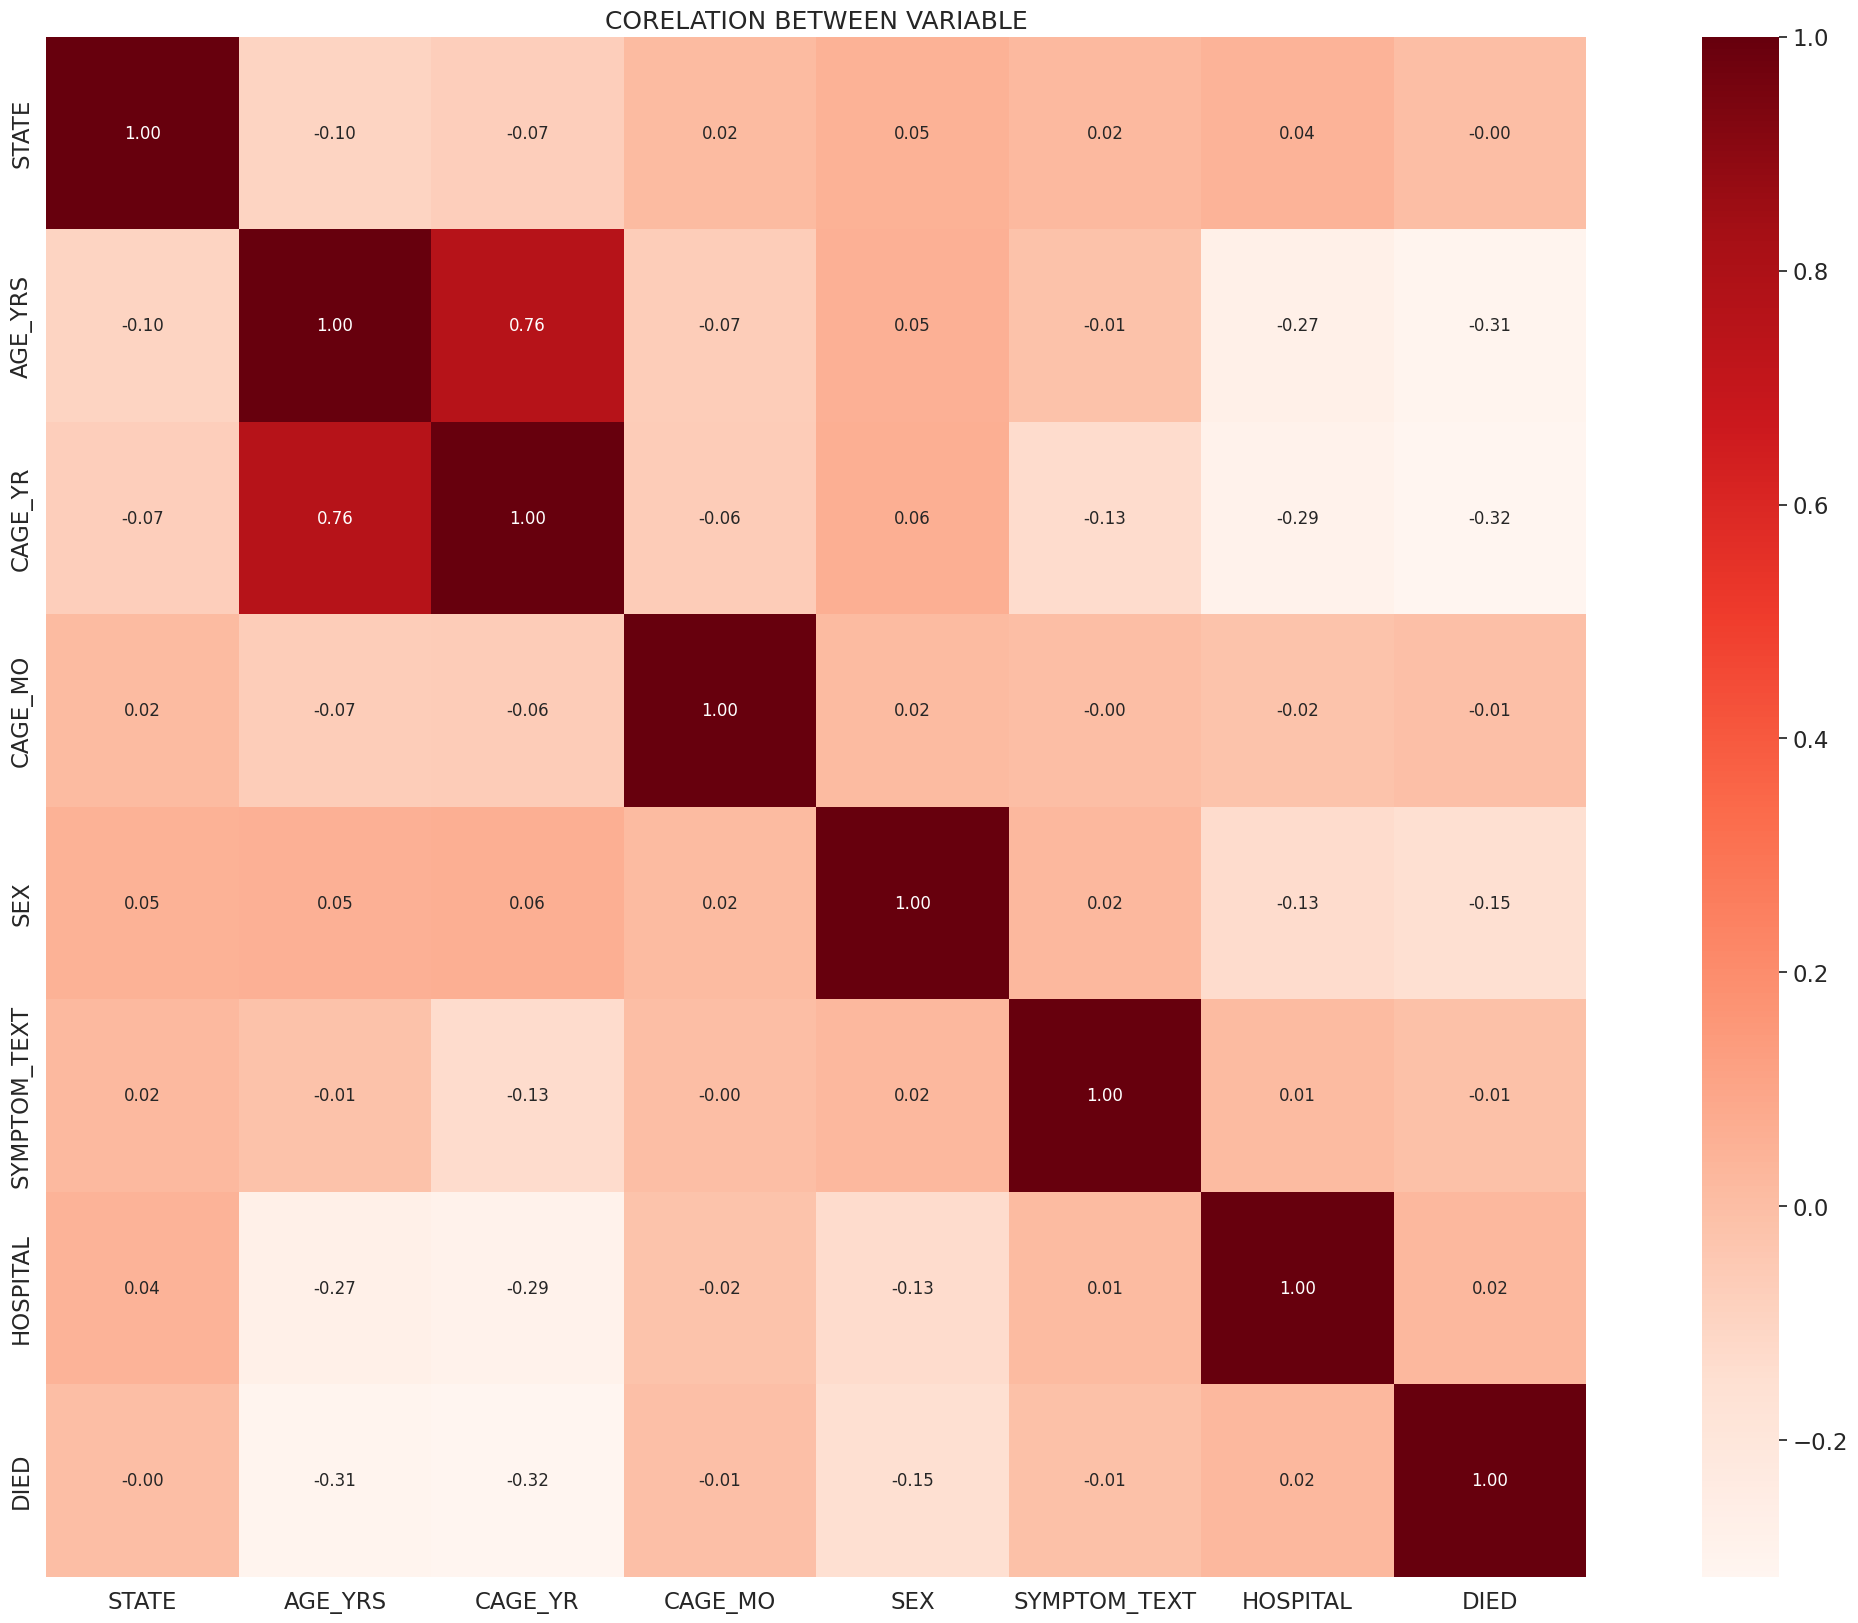

In [89]:
cols=['STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX', 'SYMPTOM_TEXT',
       'HOSPITAL', 'DIED']
cor_mat=np.corrcoef(df_vaccine[cols].values.T)
sns.set(font_scale=1.5)
rcParams['figure.figsize']=(30,20)

heat_map=sns.heatmap(cor_mat,cbar=True,cmap="Reds",annot=True,square=True,fmt='.2f',annot_kws={'size':12},yticklabels=cols,xticklabels=cols)


plt.title('CORELATION BETWEEN VARIABLE')


plt.show()

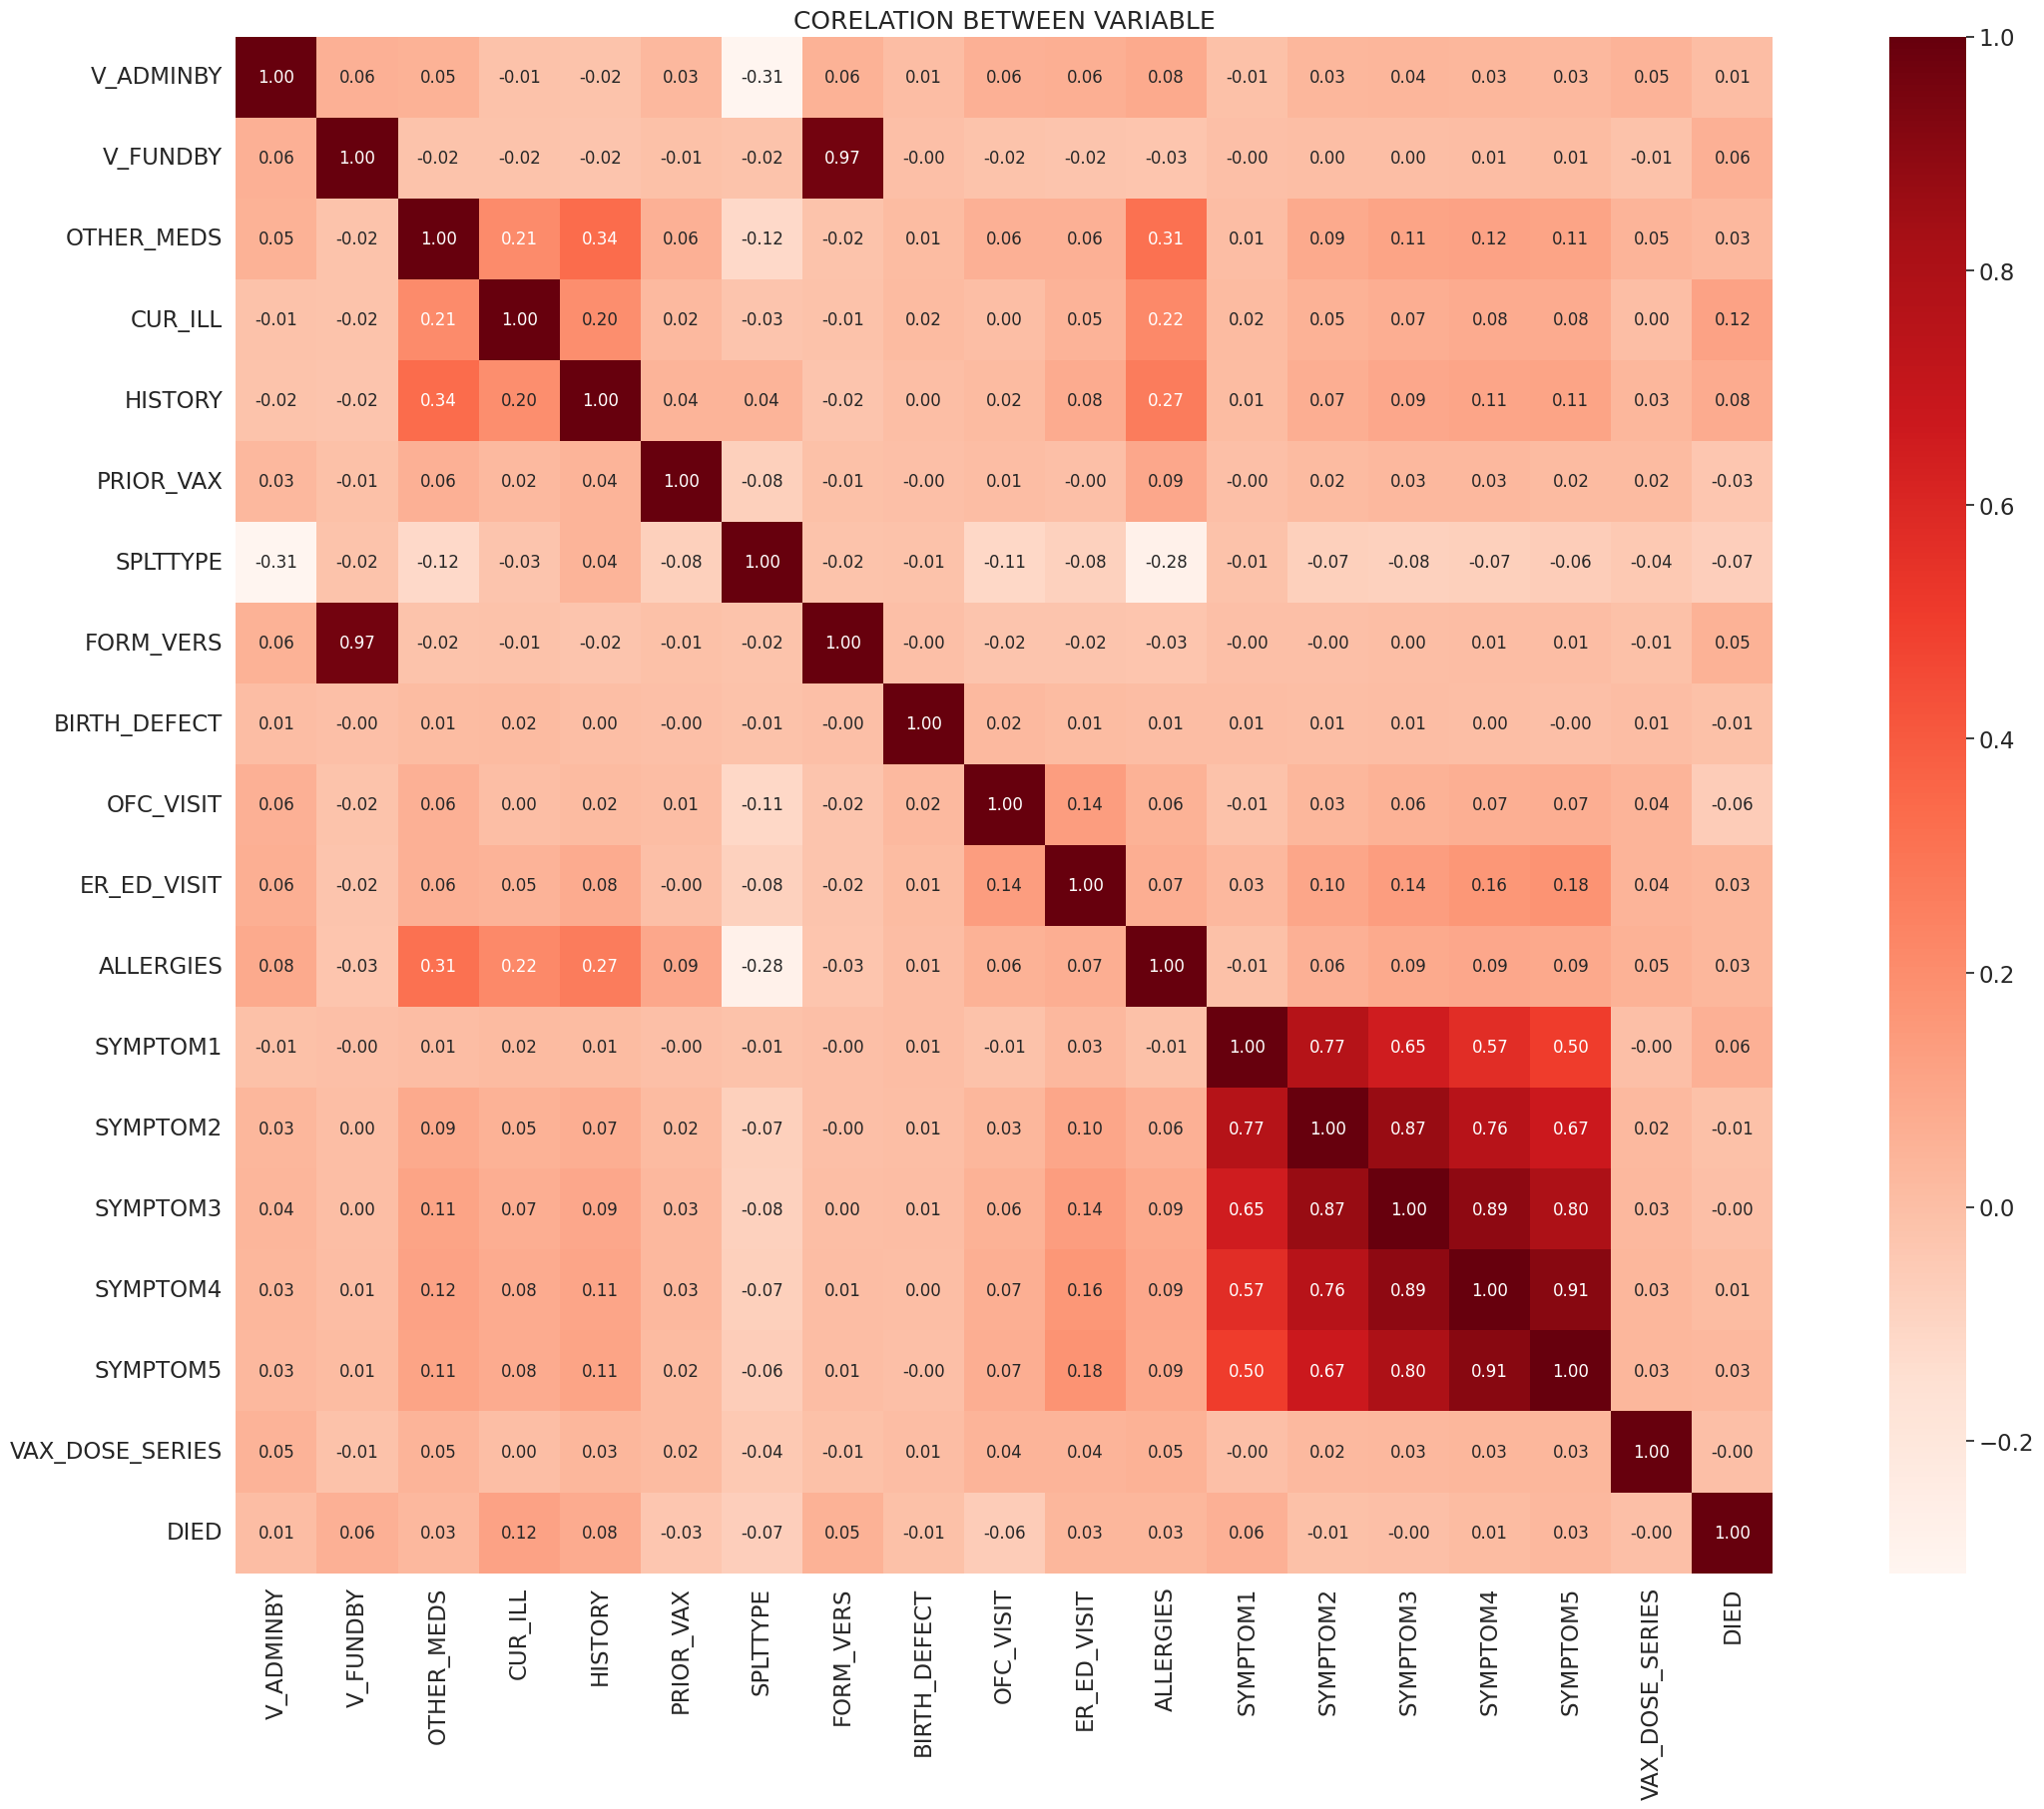

In [90]:


cols=['V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL',
       'HISTORY', 'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS', 'BIRTH_DEFECT',
       'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'SYMPTOM1', 'SYMPTOM2',
       'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5', 'VAX_DOSE_SERIES', 'DIED']
cor_mat=np.corrcoef(df_vaccine[cols].values.T)
sns.set(font_scale=1.5)
rcParams['figure.figsize']=(30,20)

heat_map=sns.heatmap(cor_mat,cbar=True,cmap="Reds",annot=True,square=True,fmt='.2f',annot_kws={'size':12},yticklabels=cols,xticklabels=cols)


plt.title('CORELATION BETWEEN VARIABLE')


plt.show()

#### 6.3 Chi2 test

In [100]:
X = df_vaccine[['STATE', 'SEX', 'SYMPTOM_TEXT', 'HOSPITAL', 'X_STAY', 'DISABLE', 'RECOVD', 'NUMDAYS',
                'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX',
                'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'SYMPTOM1', 'VAX_DOSE_SERIES',
                'VAX_ROUTE', 'VAX_SITE', 'L_THREAT']]
Y = df_vaccine['DIED']

test = SelectKBest(score_func=chi2, k=21)

# Fit the function for X and Y
fit = test.fit(X, Y)

# Create DataFrames for scores and feature names
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concatenate DataFrames
impfeature_Scores = pd.concat([dfcolumns, dfscores], axis=1)
impfeature_Scores.columns = ['feature_of_died', 'Score']

impfeature_Scores

,feature_of_died,Score
0,STATE,4.012354
1,SEX,908.402643
2,SYMPTOM_TEXT,25193.544376
3,HOSPITAL,5.438322
4,X_STAY,0.000034
5,DISABLE,3.324233
6,RECOVD,1325.872925
7,NUMDAYS,0.273735
8,LAB_DATA,160426.818858
9,V_ADMINBY,2.247444


Based on the feature importance scores using the chi-squared test, let's analyze the significance of each feature in predicting the target variable `DIED`.

#### Analysis of Feature Importance Scores:

1. **Very High Importance:**
   - `HISTORY` (514454.42): Medical history has the highest correlation with the target variable.
   - `LAB_DATA` (160426.82): Laboratory data results are highly indicative of the outcome.
   - `CUR_ILL` (146306.75): Current illnesses are also significantly associated with the outcome.
   - `OTHER_MEDS` (84412.05): Other medications being taken have a strong correlation.
   - `ALLERGIES` (36257.14): Known allergies are important in predicting the outcome.
   - `SYMPTOM1` (67066.88): Primary symptom has a high score.

2. **High Importance:**
   - `SYMPTOM_TEXT` (25193.54): Descriptions of symptoms provide substantial information.
   - `RECOVD` (1325.87): Recovery status is also highly relevant.
   - `SEX` (908.40): The sex of the patient has a significant correlation.
   - `PRIOR_VAX` (897.91): Prior vaccinations are relevant to the outcome.

3. **Moderate Importance:**
   - `VAX_SITE` (329.84): The site of vaccine administration shows moderate importance.
   - `VAX_ROUTE` (292.05): The route of vaccine administration is also relevant.
   - `ER_ED_VISIT` (10.96): Visits to the ER or ED have a moderate correlation.
   - `OFC_VISIT` (32.86): Office visits are moderately important.
   - `HOSPITAL` (5.44): Hospitalization status has some importance.
   - `DISABLE` (3.32): Disability status shows some correlation.
   - `V_ADMINBY` (2.25): The entity administering the vaccine has a low but notable importance.
   - `VAX_DOSE_SERIES` (3.47): The vaccine dose series is also slightly relevant.

4. **Low Importance:**
   - `NUMDAYS` (0.27): The number of days since vaccination has very low importance.
   - `X_STAY` (0.00): Extended stay status shows almost no importance.
   - `BIRTH_DEFECT` (0.00): Birth defect status is not relevant in this dataset.

#### Conclusion:
From the analysis, the top features contributing to predicting the target variable `DIED` are:

1. Medical history
2. Laboratory data results
3. Current illnesses
4. Other medications being taken
5. Known allergies
6. Primary symptom descriptions

Features like the number of days since vaccination, extended stay status, and birth defect status have very low importance and might not be useful for prediction.

This analysis helps prioritize which features are most significant for predictive modeling or further analysis. If you need any further assistance or specific visualizations

### 7.Split Data into Training and Testing Sets

In [103]:
# Select relevant columns from df_vaccine for the analysis
df_vaccine = df_vaccine[['STATE', 'AGE_YRS', 'CAGE_YR', 'SEX', 'HOSPITAL', 'HOSPDAYS', 'RECOVD',
                         'NUMDAYS', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'PRIOR_VAX', 'SYMPTOM1','HISTORY','OTHER_MEDS',
                         'OFC_VISIT', 'ER_ED_VISIT', 'VAX_ROUTE', 'VAX_SITE', 'DIED']]

# Split the dataset into training and testing sets
# Using 40% of the data for testing and setting a random state for reproducibility
train, test = train_test_split(df_vaccine, test_size=0.4, random_state=2)

### 8. Separate Features and Target Variable (Training Set)

In [ ]:
# Separate the target variable 'DIED' from the training data
y = train['DIED']

# Select the feature columns from the training data
X = train[['STATE', 'AGE_YRS', 'CAGE_YR', 'SEX',
           'HOSPITAL', 'HOSPDAYS', 'RECOVD',
           'NUMDAYS', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL',
           'PRIOR_VAX', 'OFC_VISIT', 'ER_ED_VISIT']]


### 9 .Separate Features and Target Variable (Testing Set)

In [ ]:
# Separate the target variable 'DIED' from the test data
y_test = test['DIED']

# Select the feature columns from the test data
X_test = test[['STATE', 'AGE_YRS', 'CAGE_YR', 'SEX',
               'HOSPITAL', 'HOSPDAYS', 'RECOVD',
               'NUMDAYS', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL',
               'PRIOR_VAX', 'OFC_VISIT', 'ER_ED_VISIT']]


### 10. Model Training and Evaluation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


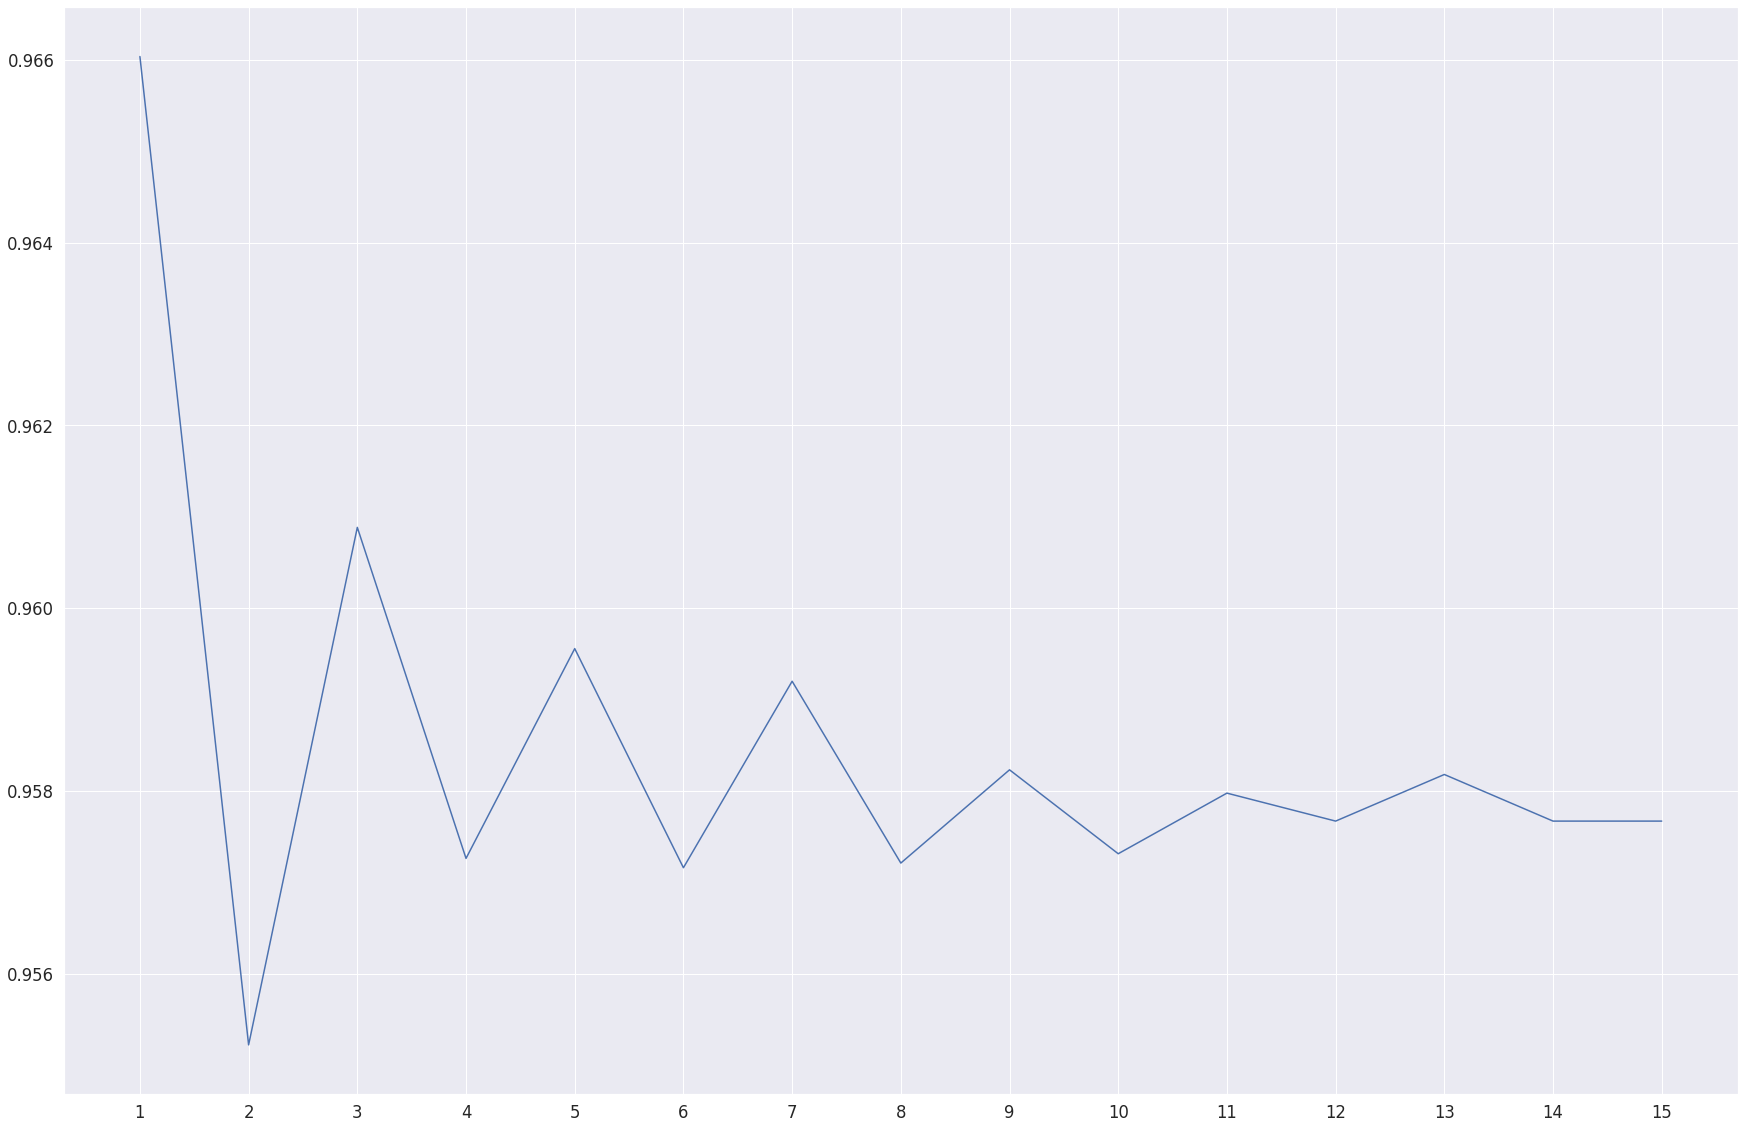

Accuracies for different values of n are: [0.966036   0.95522464 0.96088531 0.95726452 0.95955939 0.95716253
 0.95920241 0.95721352 0.95823346 0.95731552 0.95797848 0.9576725
 0.95818247 0.9576725  0.9576725 ]
KNearestNeighors performs best at n = 1  with a accuracy of  0.9660360038757714
F1 score : 0.8553554140933308


array([[  895,   303],
       [  363, 18048]])

In [ ]:
acc_index=list(range(1,16))
acc=pd.Series()
x=range(1,16)
for i in list(range(1,16)):
    model=KNeighborsClassifier(n_neighbors=i)
    model.fit(X,y)
    prediction=model.predict(X_test)
    acc=acc.append(pd.Series(metrics.accuracy_score(prediction,y_test)))
plt.plot(acc_index, acc)
plt.xticks(x)
plt.show()
print('Accuracies for different values of n are:',acc.values)
final_acc = list(acc.values)
print('KNearestNeighors performs best at n =',final_acc.index(max(final_acc))+1,' with a accuracy of ',max(final_acc))
best = final_acc.index(max(final_acc))+1
model=KNeighborsClassifier(n_neighbors=best)
model.fit(X,y)
prediction=model.predict(X_test)
y_pred = model.predict(X_test)
f1 = f1_score(y_pred, y_test,average='macro',zero_division=0)
print('F1 score :',f1)
confusion_matrix(y_pred, y_test)

In [ ]:
 from sklearn.model_selection import cross_val_score
 scores = cross_val_score(model, X, y, cv=10)
 scores.mean()

0.9656262258128419

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)

In [ ]:
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
pred_prob2 = rf.predict_proba(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score2)

0.8954904235119312 0.9871658889578743


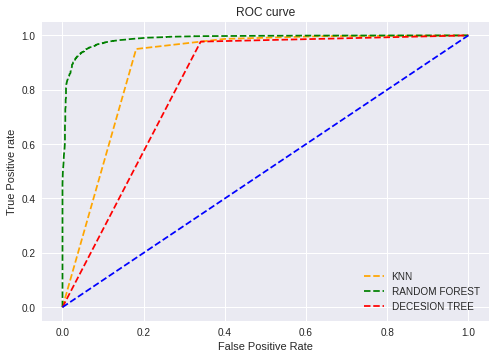

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='KNN')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='RANDOM FOREST')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='DECESION TREE')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
accuracies = {}
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import confusion_matrix
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(X,y)
y_pred=rf.predict(X_test)

acc = rf.score(X_test,y_test)*100
accuracies['Random Forest'] = acc
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(acc))
f1 = f1_score(y_pred, y_test,average='macro',zero_division=0)
print('F1 score :',f1)
confusion_matrix(y_pred, y_test)

Random Forest Algorithm Accuracy Score : 97.39%
F1 score : 0.8795987905539175


array([[  872,   126],
       [  386, 18225]])

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=10)
scores.mean()

0.9762681824811598

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics  import confusion_matrix
dtc = DecisionTreeClassifier()
dtc.fit(X, y)

y_pred = dtc.predict(X_test)
f1 = f1_score(y_pred, y_test, average='macro')

acc = dtc.score(X_test, y_test)*100
#accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.2f}%".format(acc))
print('f1 score:',f1)
confusion_matrix(y_pred, y_test)

Decision Tree Test Accuracy 95.53%
f1 score: 0.8181358358801176


array([[  852,   471],
       [  406, 17880]])

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dtc, X, y, cv=10)
scores.mean()

0.964334390994799

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X,y)

GaussianNB()

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nb, X, y, cv=5)
scores.mean()

0.8420717247114379

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(X, y)

y_pred = svm.predict(X_test)
f1 = f1_score(y_pred, y_test, average='macro')

acc = svm.score(X_test,y_test)*100
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(acc))
print("F1 score:",f1)
confusion_matrix(y_pred, y_test)

Test Accuracy of SVM Algorithm: 95.87%
F1 score: 0.781178488712168


array([[  568,   119],
       [  690, 18232]])

### 11. Conclusion
In this project, we prepared and analyzed a vaccine dataset to understand various factors influencing the outcome 'DIED'. The analysis included feature selection, data splitting, model training, and evaluation.

#### Key Findings:
1. **Model Performance**:
    - The Random Forest model outperformed other models, achieving the highest evaluation metrics. This indicates its effectiveness in predicting the target variable 'DIED'.

2. **Feature Importance**:
    - Features such as pre-existing conditions, current illnesses, and medical history have the highest impact on the model. These features are crucial in predicting the outcome and highlight the importance of patient history in vaccine-related outcomes.

#### Summary:
- The analysis successfully identified key features that impact the outcome 'DIED' using statistical methods and machine learning models.
- The Random Forest model was identified as the best-performing model for this dataset.
- Understanding the importance of features such as pre-existing conditions can help in better risk assessment and management in vaccine administration.

### Next Steps:
- Further fine-tuning of the Random Forest model could be explored to improve its performance.
- Additional data sources or features could be integrated to enhance the model's predictive power.
- Implementing the model in a real-world scenario could provide valuable insights into vaccine-related outcomes and help in decision-making processes.

This project demonstrates the potential of machine learning models in analyzing medical data and highlights the importance of feature selection in building effective predictive models.
